In [1]:
import gym

from tqdm.notebook import tqdm  # Progress bar

import numpy as np
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
# Memory class to store the previous experiences
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

In [3]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')
action_size = 2
state_size = 4

In [4]:
pretrain_length = batch_size = 100
memory_size = 10000

# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())
memory = Memory(max_size=memory_size)
# Make a bunch of random actions and store the experiences
for _ in range(pretrain_length): # Do a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    if done:
        # Simulation fails, so no next state
        # next_state = np.zeros(state.shape)

        # Add experience to memory
        memory.add((state, action, reward, next_state))
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [5]:
def get_epsilon(t, e_min=0.005, e_max=1, alpha=0.001):
    return e_min + (e_max - e_min) * np.exp(-alpha * t)

In [6]:
class Net(nn.Module):
    def __init__(self, state_size, action_size, hidden_dim=64, lr=0.0001):
        super(Net, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(state_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_size)
        )
        self.optimizer = optim.Adam(self.linear.parameters(), lr, eps=0.01)
        self.criterion = nn.MSELoss()

    def update(self, output, target):
        loss = self.criterion(output, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def forward(self, states):
        return self.linear(torch.Tensor(states))


In [263]:
net = Net(state_size, action_size)

num_episodes = 400
discount = 0.99
max_t = 200

total_reward_list = []

t = 0

for episode in range(num_episodes):
    total_reward = 0
    done = False
    state = env.reset()
    
    while not done:

        t += 1

        # Choose an action based on epsilon-greedy
        if np.random.random() < get_epsilon(t):
            action = env.action_space.sample()
        else:
            q_values = net(torch.from_numpy(state))
            action = torch.argmax(q_values).item()

        # Take the action and observe the reward and next state
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Add experience to memory. If the episode is over, there is no next state
        if done:
            next_state = np.zeros(state.shape)
        memory.add((state, action, reward, next_state))

        # Sample a mini batch from memory
        batch = memory.sample(batch_size)
        states, actions, rewards, next_states = map(np.array, zip(*batch))

        # Compute the targets. If the episode is over, the target is the reward
        Q_targets = net.forward(states).detach()
        Q_next, _ = torch.max(net.forward(next_states).detach(), axis=1)
        for i in range(batch_size):
            if not next_states[i].any():
                Q_targets[i, actions[i]] = rewards[i]
            else:
                Q_targets[i, actions[i]] = rewards[i] + discount * Q_next[i]
        
        # Update the network
        output = net.forward(states)
        net.update(output, Q_targets)

        # Update the state
        state = next_state

        # Stop if the number of iterations is greater than the allowed number
        if i > max_t:
            done = True

    total_reward_list.append((episode, total_reward))


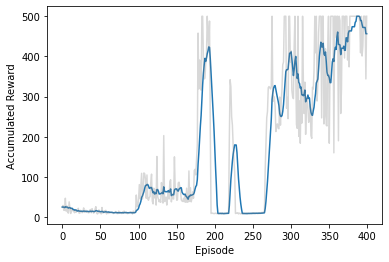

In [264]:
# Moving average for smoothing plot
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, x[0]*np.ones(N)))
    return (cumsum[N:] - cumsum[:-N]) / N

eps, rews = np.array(total_reward_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps, smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.savefig('DQN.png')